# Fig 1: Exit energy spectra split on number of scatter events at exit 

### Imports and configuration

In [21]:
from pathlib import Path
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sas_pet import photon_shards
from sas_pet.spectra import load_photon_shards, filter_detected_photons, stacked_energy_histograms

In [22]:
MC_DATA_ROOT = Path("../results/MC_data_1e7")
Rs = [5.0, 10.0, 15.0]

MAX_SCAT_HIST = 5
BINS = 511

COLUMNWIDTH_PT = 242.5389
INCH_PER_PT = 1 / 72.27
FIG_W = COLUMNWIDTH_PT * INCH_PER_PT
FIG_W_WIDE = FIG_W * 2.25
FIG_H_WIDE = FIG_W * 0.80

FONTSIZE = 10
TICKLABELSIZE = 8

CMAP = plt.cm.inferno
CMAP_MIN, CMAP_MAX = 0.20, 0.85

In [23]:
mpl.rcParams.update({
    "text.usetex": False,
    "font.family": "serif",
    "mathtext.fontset": "cm",
    "font.size": FONTSIZE,
    "axes.labelsize": TICKLABELSIZE,
    "xtick.labelsize": TICKLABELSIZE,
    "ytick.labelsize": TICKLABELSIZE,
    "figure.dpi": 150,
    "savefig.dpi": 300,
    "axes.grid": True,
    "axes.axisbelow": True,
    "grid.alpha": 0.9,
    "grid.color": "white",
    "grid.linewidth": 1.0,
    "axes.facecolor": "white",
})

### Load data

In [24]:
df_by_R = {}

for R in Rs:
    paths = photon_shards(MC_DATA_ROOT, R)
    df = load_photon_shards(paths)
    df = filter_detected_photons(df)
    df_by_R[R] = df

    n_ph = len(df)
    print(f"R={R:.0f} cm: photons={n_ph:,}")

R=5 cm: photons=19,931,171
R=10 cm: photons=19,380,009
R=15 cm: photons=18,247,794


### Create histograms

In [25]:
hist_by_R = {}

for R in Rs:
    df = df_by_R[R]
    centers, bw, labels, H = stacked_energy_histograms(
        df["E_exit_keV"].to_numpy(float),
        df["n_object_scatters"].to_numpy(int),
        max_scat=MAX_SCAT_HIST,
        bins=BINS,
    )
    hist_by_R[R] = (centers, bw, labels, H)

    print(f"R={R:.0f} cm: categories={labels}")

R=5 cm: categories=['1', '2', '3', '4', '5', '>5']
R=10 cm: categories=['1', '2', '3', '4', '5', '>5']
R=15 cm: categories=['1', '2', '3', '4', '5', '>5']


### Visualize

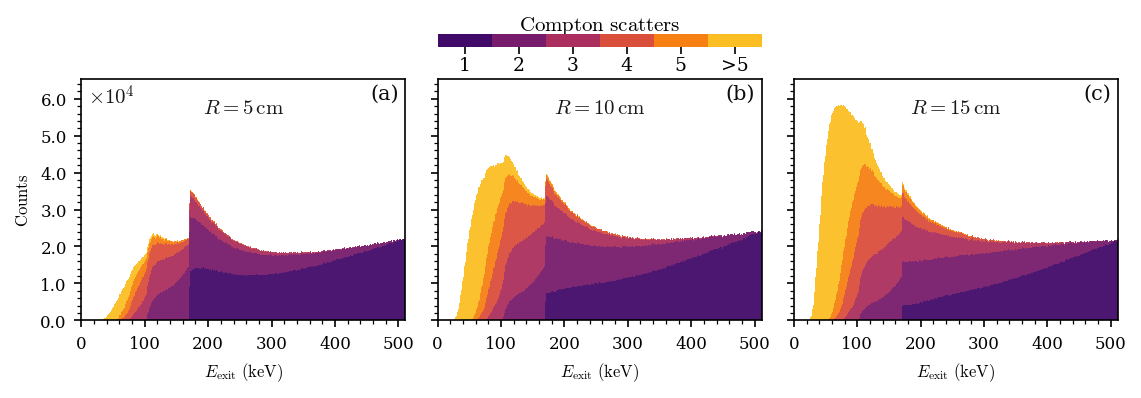

In [26]:
fig, axes = plt.subplots(1, 3, figsize=(FIG_W_WIDE, FIG_H_WIDE), sharey=True)
fig.subplots_adjust(left=0.07, right=0.985, top=0.80, bottom=0.20, wspace=0.10)

panel_tags = ["(a)", "(b)", "(c)"]
hatches = ["", "//", "\\\\", "xx", "..", "++", "oo"]
labels_mid = None
colors_mid = None

for i, R in enumerate(Rs):
    ax = axes[i]
    centers, bw, labels, H = hist_by_R[R]

    colors = CMAP(np.linspace(CMAP_MIN, CMAP_MAX, len(labels)))

    bottoms = np.zeros_like(centers, dtype=float)
    total = np.zeros_like(centers, dtype=float)

    for j, (lab, col, h) in enumerate(zip(labels, colors, H)):
        ax.bar(
            centers,
            h,
            width=bw,
            bottom=bottoms,
            color=col,
            edgecolor=col,
            linewidth=0.0,
            alpha=0.95,
            align="center",
            #hatch=hatches[j % len(hatches)],
        )
        bottoms += h
        total += h

    ax.set_xlim(0.0, 511.0)
    ax.set_xticks([0, 100, 200, 300, 400, 500])
    ax.set_xlabel(r"$E_{\mathrm{exit}}\ \mathrm{(keV)}$")

    if i == 0:
        ax.set_ylabel(r"$\mathrm{Counts}$")

    ymax = float(np.ceil(total.max() * 1.12)) if total.max() > 0 else 1.0
    ax.set_ylim(0.0, ymax)

    sf = mpl.ticker.ScalarFormatter(useMathText=True)
    sf.set_scientific(True)
    sf.set_powerlimits((0, 0))
    ax.yaxis.set_major_formatter(sf)
    fig.canvas.draw()

    oom = ax.yaxis.get_major_formatter().orderOfMagnitude
    ax.yaxis.offsetText.set_visible(False)
    scale = 10.0 ** oom if oom != 0 else 1.0
    ax.yaxis.set_major_formatter(
        mpl.ticker.FuncFormatter(lambda y, pos, s=scale: f"{(y/s):.1f}")
    )

    if i == 0:
        ax.text(
            0.02, 0.98, rf"$\times 10^{{{oom}}}$",
            transform=ax.transAxes,
            ha="left", va="top",
            fontsize=FONTSIZE,
            alpha=0.9,
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.7, pad=1.0),
            zorder=10,
        )

    ax.text(
        0.98, 0.98, panel_tags[i],
        transform=ax.transAxes,
        ha="right", va="top",
        fontsize=FONTSIZE,
        alpha=0.95,
        bbox=dict(facecolor="white", edgecolor="none", alpha=0.75, pad=1.0),
        zorder=10,
    )

    ax.text(
        0.5, 0.92, rf"$R={R:.0f}\,\mathrm{{cm}}$",
        transform=ax.transAxes,
        ha="center", va="top",
        fontsize=FONTSIZE,
        alpha=0.9,
        bbox=dict(boxstyle="round,pad=0.25", facecolor="white", edgecolor="none", alpha=0.85),
        zorder=10,
    )

    ax.minorticks_on()
    #ax.grid(True, which="major")
    #ax.grid(True, which="minor", alpha=0.30, linewidth=0.9)

    if np.isclose(R, 10.0):
        labels_mid = labels
        colors_mid = colors

if labels_mid is None or colors_mid is None:
    labels_mid = [str(i) for i in range(1, MAX_SCAT_HIST + 1)] + [f">{MAX_SCAT_HIST}"]
    colors_mid = CMAP(np.linspace(CMAP_MIN, CMAP_MAX, len(labels_mid)))

N = len(labels_mid)
bounds = np.arange(N + 1)
norm = mpl.colors.BoundaryNorm(bounds, ncolors=N)

sm = mpl.cm.ScalarMappable(
    cmap=mpl.colors.ListedColormap(colors_mid),
    norm=norm,
)
sm.set_array([])

pos0 = axes[1].get_position()
pos2 = axes[1].get_position()
cax = fig.add_axes([pos0.x0, pos0.y1 + 0.08, pos2.x1 - pos0.x0, 0.03])

cbar = fig.colorbar(
    sm,
    cax=cax,
    orientation="horizontal",
    ticks=np.arange(N) + 0.5,
    drawedges=False,
)
cbar.ax.set_xticklabels(labels_mid)
cbar.set_label(r"$\mathrm{Compton\ scatters}$", fontsize=FONTSIZE, labelpad=2.0)
cbar.ax.xaxis.set_label_position("top")
cbar.ax.xaxis.set_ticks_position("bottom")
cbar.ax.tick_params(axis="x", labelsize=9, pad=1)
cbar.outline.set_visible(False)
cbar.ax.tick_params(which="minor", bottom=False, top=False)


plt.show()


### Gray scale preview

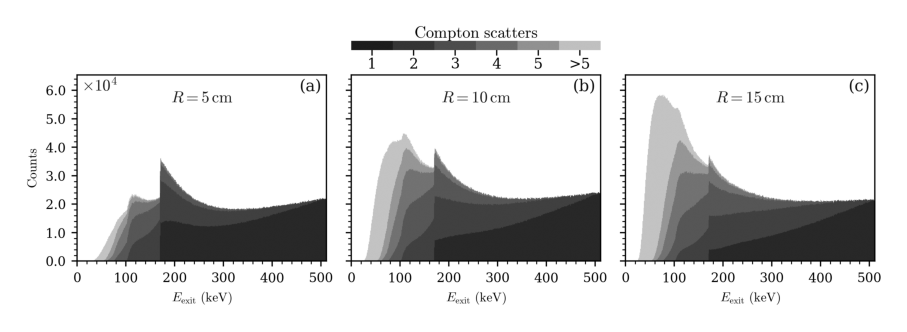

In [30]:
import os
tmp_path = "tmp_preview.png"
fig.savefig(tmp_path, dpi=400, bbox_inches="tight")
img = plt.imread(tmp_path)
rgb = img[..., :3].astype(np.float32)

gray = (
    0.2126 * rgb[..., 0]
    + 0.7152 * rgb[..., 1]
    + 0.0722 * rgb[..., 2]
)
os.remove(tmp_path)
fig_gs, ax_gs = plt.subplots(figsize=(FIG_W_WIDE, FIG_H_WIDE))
ax_gs.imshow(gray, cmap="gray")
ax_gs.axis("off")
plt.show()

### Save

In [28]:
out_dir = Path("../results/figures/energy_spectra")
out_dir.mkdir(parents=True, exist_ok=True)

fig.savefig(out_dir / "energy_spectra_all.pdf", bbox_inches="tight", pad_inches=0.02, transparent=False,dpi=300)
fig.savefig(out_dir / "energy_spectra_all.svg", bbox_inches="tight", pad_inches=0.02, transparent=False,dpi=300)

In [29]:
fig.canvas.draw()  
for i, ax in enumerate(axes):
    R = Rs[i]
    tag = panel_tags[i].strip("()")

    bbox = ax.get_tightbbox(fig.canvas.get_renderer())

    bbox = bbox.transformed(fig.dpi_scale_trans.inverted())

    out_base = out_dir / f"energy_spectra_R{int(round(float(R)))}"

    fig.savefig(out_base.with_suffix(".pdf"),
                bbox_inches=bbox,
                pad_inches=0.02,
                transparent=False,
                dpi=300)

    fig.savefig(out_base.with_suffix(".svg"),
                bbox_inches=bbox,
                pad_inches=0.02,
                transparent=False,
                dpi=300)